(256, 216, 3)


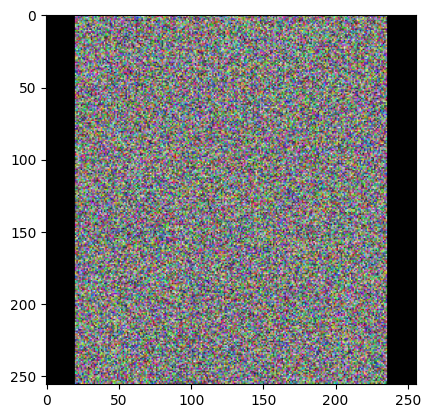

In [36]:
from src.dl_data_pipeline.validator import TypeValidator, ShapeValidator, MinMaxValidator, MeanVarValidator
from src.dl_data_pipeline.pipeline.pipe_node import PipeNode
from src.dl_data_pipeline.pipeline.data_pipeline import Pipeline
from src.dl_data_pipeline import deferred_execution
from src.dl_data_pipeline.process_functions import (any_process, process_2d)
import numpy as np

@deferred_execution
def print_infos(x):
    print(x.shape)
    return x

input1 = PipeNode(name = "Input1")
x = any_process.rescale(input1, 0, 1)
x = process_2d.resize_with_max_distortion(x, (256, 256), 0.5)
x = print_infos(x)
x = process_2d.padding_2d(x, (256, 256), 0)

pipe = Pipeline([input1], x)
pipe.add_validator(TypeValidator(np.ndarray), 0)
pipe.add_validator(ShapeValidator((256, 256, 3)), 0)

import matplotlib.pyplot as plt
plt.imshow(pipe(np.random.rand(1920, 1080, 3)))